# Argo Sample Rate

This notebook will investigate the sample rate of argo floats and how to account for this while loading boxes, interpolating to a standard pressure grid, and performing analysis. This is important to resolve because some (many?) profiles seem to have sampling rates of >100m, which would greatly interfere with the accuracy of filtering analysis, particularly at small scales. See this issue for more specific thoughts on how to address this: https://github.com/ocean-transport/argo-intern/issues/12#issuecomment-1655683014

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home.ufs/amf2288/argo-intern/MLD_funcs.py'>

In [3]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader=ArgoDataFetcher(src='gdac',ftp="/swot/SUM05/dbalwada/Argo_sync",parallel=True,progress=True)

ds = argo_loader.region([-10,0,-40,-30,0,2000])
print('loading points complete')
ds = ds.to_xarray()
print('to xarray complete')
ds = ds.argo.point2profile()
print('point to profile complete')

loading points complete
to xarray complete
point to profile complete


In [11]:
depth_min, depth_max = 0, 2000
rate = 4

median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
ind_rate=median_dp.where(median_dp<rate,drop=True).N_PROF
ds_sel=ds.sel(N_PROF=ind_rate)

ds_rate = ds_sel.PRES.diff('N_LEVELS').sortby('N_PROF')

In [ ]:
#does diff reduce by one, when adding sample_rate as variable does it fill last point with nan

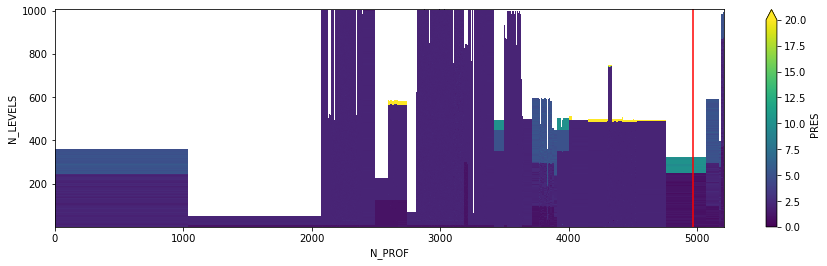

In [104]:
plt.figure(figsize=(15,4))
ds_rate.plot(x='N_PROF',y='N_LEVELS',vmin=0,vmax=20)
plt.axvline(4970,0,1000,color='r')#,linewidth=30)

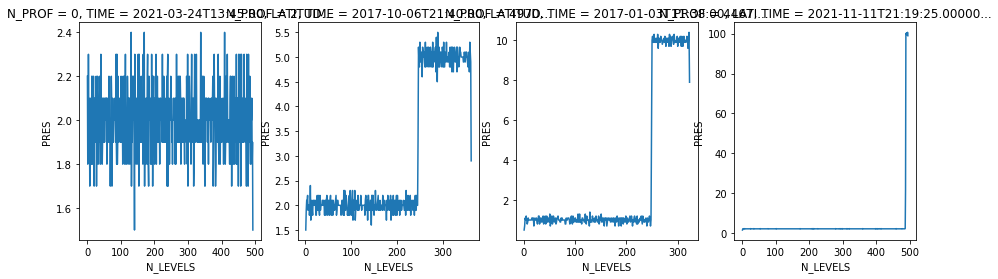

In [106]:
plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
ds_rate.isel(N_PROF=0).plot()
plt.subplot(1,4,2)
ds_rate.isel(N_PROF=1).plot()
plt.subplot(1,4,3)
ds_rate.isel(N_PROF=1475).plot()
plt.subplot(1,4,4)
ds_rate.isel(N_PROF=1400).plot()

In [13]:
ds['sample_rate'] = ds_rate
ds_interp = ff.get_ds_interp(ds,0,2000,4)

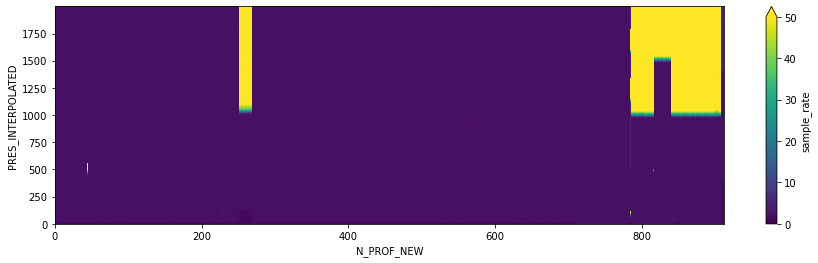

In [68]:
plt.figure(figsize=(15,4))
ds_interp.sample_rate.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=0,vmax=50)

In [110]:
#try process with one profile, follow through all steps, check intuition

In [ ]:
#for filtering: only take the part of the profile that has a sample rate >5m

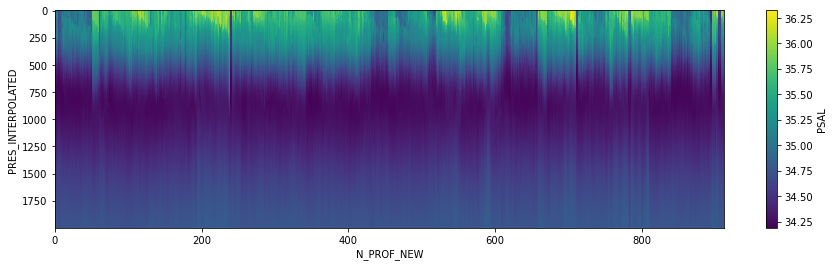

In [109]:
plt.figure(figsize=(15,4))
ds_interp.PSAL.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

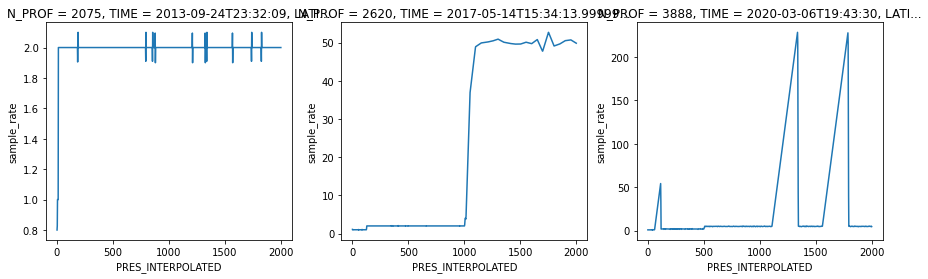

In [57]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
ds_interp.sample_rate.isel(N_PROF=0).plot()
plt.subplot(1,3,2)
ds_interp.sample_rate.isel(N_PROF=260).plot()
plt.subplot(1,3,3)
ds_interp.sample_rate.isel(N_PROF=785).plot()